In [24]:
import torch, pickle, math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Import Data

In [2]:
file = open('data-250-125.pkl', 'rb')
df = pickle.load(file)
file.close()

In [3]:
df.head()

,subject,day,session,motion,repetition,window_emg
0,sub03,D3,S1,OH,1,"[[0.4140625, 0.6015625, -0.203125, -0.2109375,..."
1,sub03,D3,S1,OH,1,"[[0.2421875, -0.0546875, -0.0078125, 0.015625,..."
2,sub03,D3,S1,OH,1,"[[-0.5546875, -0.125, -0.0625, -0.0234375, -0...."
3,sub03,D3,S1,OH,1,"[[-0.1953125, -0.0625, -0.265625, -0.0234375, ..."
4,sub03,D3,S1,OH,1,"[[0.0703125, -0.1484375, 0.171875, -0.015625, ..."


In [4]:
df.subject.value_counts()

subject
sub03    83700
sub04    83700
sub05    83700
sub02    83700
sub07    83700
sub01    83700
sub06    83700
Name: count, dtype: int64

## Prepocessing

### Change Labels into Numerics

In [5]:
df['label'] = df.motion.replace(
    df.motion.drop_duplicates().tolist(),
    [i for i in range(9)]
)

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_67968/4281264563.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.motion.replace(


In [6]:
df.subject.value_counts()

subject
sub03    83700
sub04    83700
sub05    83700
sub02    83700
sub07    83700
sub01    83700
sub06    83700
Name: count, dtype: int64

### Create Subset DF for Initial Training

In [7]:
sub1_min = df[(df.subject == 'sub01') & (df.session == 'S1')].reset_index(drop=True)

In [8]:
X1_train, X1_test, y1_train, y1_test = train_test_split(np.stack(sub1_min.window_emg.to_numpy()),
                                                        sub1_min.label.to_numpy(), 
                                                        test_size=.2, 
                                                        random_state=42)

In [9]:
device = 'mps'

In [10]:
X1_train_tensor = torch.FloatTensor(X1_train).to(device)
X1_test_tensor = torch.FloatTensor(X1_test).to(device)
y1_train = torch.FloatTensor(y1_train).to(device)
y1_test = torch.FloatTensor(y1_test).to(device)

In [11]:
train1_set = TensorDataset(X1_train_tensor, y1_train)
val1_set = TensorDataset(X1_test_tensor, y1_test)

## Bulding Model Architecture

In [36]:
z = torch.zeros(1, 40, 8)

In [28]:
a = torch.arange(0, 40, dtype=torch.float).unsqueeze(1)

In [30]:
b = torch.exp(torch.arange(0, 8, 2).float() * (-math.log(10000.0) / 8))

In [38]:
z[0, :, 0::2] = torch.sin(a * b)
z[0, :, 1::2] = torch.cos(a * b)

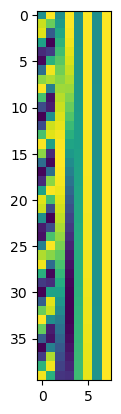

In [45]:
plt.imshow(z.squeeze(0))

In [46]:
X1_train_tensor.shape

torch.Size([33480, 50, 8])

In [50]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()

        pos_encod = torch.zeros(1, max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # 0 to max_len
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.) / d_model)) # 10000^-(2i / d_model)
        pos_encod[0, :, 0::2] = torch.sin(pos * div_term)
        pos_encod[0, :, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pos_encod', pos_encod)

    def forward(self, x):
        return x + self.pos_encod[:, :x.size(1), :]

In [72]:
pos_encod = PositionalEncoding(8, max_len=50)
pos_encod.to('mps')

PositionalEncoding()

In [55]:
X1_train_tensor[0].shape

torch.Size([50, 8])

In [66]:
X1_train_tensor[0].unsqueeze(0).shape

torch.Size([1, 50, 8])

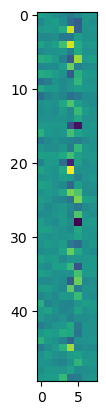

In [70]:
plt.imshow(X1_train_tensor[0].cpu())

In [74]:
a = pos_encod(X1_train_tensor[0].unsqueeze(0))

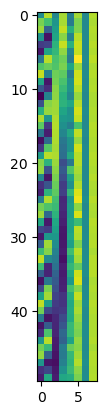

In [77]:
plt.imshow(a.squeeze().cpu())

In [80]:
class Transformer(nn.Module):
    def __init__(self, d_model, n_classes, n_heads=8, n_layers=1, dim_feedforward=256, max_len=1000):
        super(Transformer, self).__init__()

        self.pos_encod = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.pos_encod(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)

        return x

In [120]:
class ClassTokenTransformer(nn.Module):
    def __init__(self, d_model, n_classes, n_heads=8, n_layers=1, dim_feedforward=256, max_len=1000):
        super(ClassTokenTransformer, self).__init__()

        self.pos_encod = PositionalEncoding(d_model, max_len)
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.pos_encod(x)
        class_tokens = self.class_token.expand(x.shape[0], -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x = self.transformer_encoder(x)
        x = x[:, 0]
        x = self.fc(x)

        return x

In [121]:
t = ClassTokenTransformer(8, 9, max_len=50)
t.to('mps')

ClassTokenTransformer(
  (pos_encod): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=8, out_features=9, bias=True)
)

In [122]:
t(X1_train_tensor[0].unsqueeze(0))

tensor([[-0.5524,  0.1186, -0.7013, -0.7685, -0.5124, -1.2493, -0.1372,  1.3824,
         -0.3404]], device='mps:0', grad_fn=<LinearBackward0>)

## Pre-Evaluation Training

In [87]:
def train_model(model, train_set, val_set, criterion, optimizer, num_epochs, batch_size):
    device = 'mps'
    model.to(device)
    train_loader = DataLoader(train_set, batch_size=batch_size)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    train_loss = list()
    val_loss = list()
    val_acc = list()
    train_acc = list()

    for epoch in range(num_epochs):
        model.train()
        train_total_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()

        # Keep tab on the train loss every epoch
        train_loss.append(train_total_loss / len(train_loader))
        accuracy = 100 * correct / total
        train_acc.append(accuracy)

        model.eval()
        correct = 0
        total = 0
        val_total_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(val_total_loss / len(val_loader))

        accuracy = 100 * correct / total
        val_acc.append(accuracy)
        val_acc
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%')

    return model, train_loss, val_loss, val_acc

In [115]:
d_model = 8
max_len=50
n_classes = 9
n_epochs = 50
batch_size = 128

model = Transformer(d_model, n_classes, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

model, train_loss, val_loss, val_acc = train_model(model, train1_set, val1_set, criterion, optimizer, n_epochs, batch_size)

Epoch [1/50], Validation Accuracy: 17.98%
Epoch [2/50], Validation Accuracy: 36.49%
Epoch [3/50], Validation Accuracy: 29.59%
Epoch [4/50], Validation Accuracy: 59.80%
Epoch [5/50], Validation Accuracy: 63.27%
Epoch [6/50], Validation Accuracy: 65.84%
Epoch [7/50], Validation Accuracy: 67.18%
Epoch [8/50], Validation Accuracy: 67.60%
Epoch [9/50], Validation Accuracy: 68.67%
Epoch [10/50], Validation Accuracy: 69.21%
Epoch [11/50], Validation Accuracy: 69.86%
Epoch [12/50], Validation Accuracy: 70.37%
Epoch [13/50], Validation Accuracy: 72.41%
Epoch [14/50], Validation Accuracy: 72.54%
Epoch [15/50], Validation Accuracy: 75.59%
Epoch [16/50], Validation Accuracy: 75.48%
Epoch [17/50], Validation Accuracy: 76.52%
Epoch [18/50], Validation Accuracy: 75.87%
Epoch [19/50], Validation Accuracy: 78.14%
Epoch [20/50], Validation Accuracy: 77.38%
Epoch [21/50], Validation Accuracy: 76.79%
Epoch [22/50], Validation Accuracy: 78.89%
Epoch [23/50], Validation Accuracy: 79.52%
Epoch [24/50], Valid

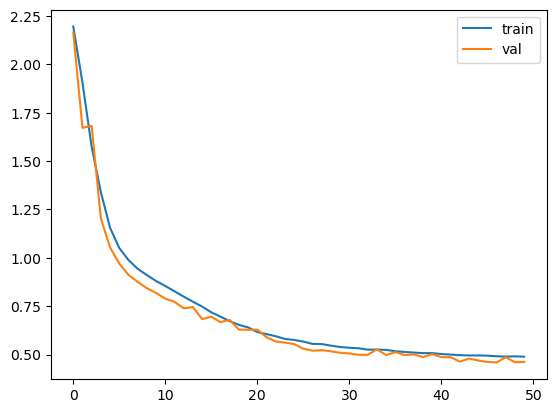

In [116]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')

plt.legend()
plt.show()

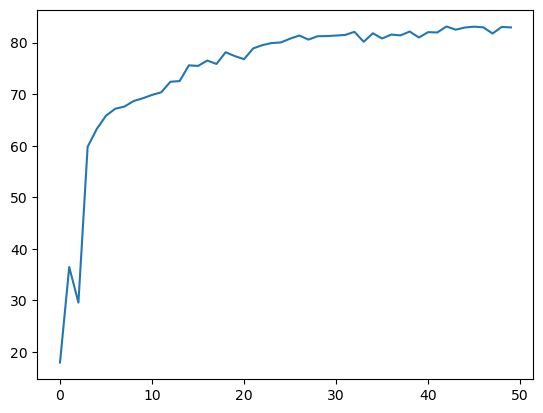

In [117]:
plt.plot(val_acc)

In [129]:
d_model = 8
max_len=50
n_classes = 9
n_epochs = 50
batch_size = 128

model1 = ClassTokenTransformer(d_model, n_classes, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.000001)

model, train_loss, val_loss, val_acc = train_model(model1, train1_set, val1_set, criterion, optimizer, n_epochs, batch_size)

Epoch [1/50], Validation Accuracy: 10.68%
Epoch [2/50], Validation Accuracy: 10.68%
Epoch [3/50], Validation Accuracy: 10.68%
Epoch [4/50], Validation Accuracy: 10.68%
Epoch [5/50], Validation Accuracy: 10.68%
Epoch [6/50], Validation Accuracy: 10.68%


KeyboardInterrupt: 

In [134]:
d_model = 8
max_len=50
n_classes = 9
n_epochs = 50
batch_size = 128
dim_feedforward=512

model = Transformer(d_model, n_classes, dim_feedforward=dim_feedforward, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model, train_loss, val_loss, val_acc = train_model(model, train1_set, val1_set, criterion, optimizer, n_epochs, batch_size)

Epoch [1/50], Validation Accuracy: 19.09%
Epoch [2/50], Validation Accuracy: 45.97%
Epoch [3/50], Validation Accuracy: 49.58%
Epoch [4/50], Validation Accuracy: 62.56%
Epoch [5/50], Validation Accuracy: 68.53%
Epoch [6/50], Validation Accuracy: 70.88%
Epoch [7/50], Validation Accuracy: 71.24%
Epoch [8/50], Validation Accuracy: 73.64%
Epoch [9/50], Validation Accuracy: 78.38%
Epoch [10/50], Validation Accuracy: 79.80%
Epoch [11/50], Validation Accuracy: 80.29%
Epoch [12/50], Validation Accuracy: 82.22%
Epoch [13/50], Validation Accuracy: 82.51%
Epoch [14/50], Validation Accuracy: 83.32%
Epoch [15/50], Validation Accuracy: 83.87%
Epoch [16/50], Validation Accuracy: 83.48%
Epoch [17/50], Validation Accuracy: 84.11%
Epoch [18/50], Validation Accuracy: 83.49%
Epoch [19/50], Validation Accuracy: 84.17%
Epoch [20/50], Validation Accuracy: 84.19%
Epoch [21/50], Validation Accuracy: 83.73%
Epoch [22/50], Validation Accuracy: 83.91%
Epoch [23/50], Validation Accuracy: 84.19%
Epoch [24/50], Valid

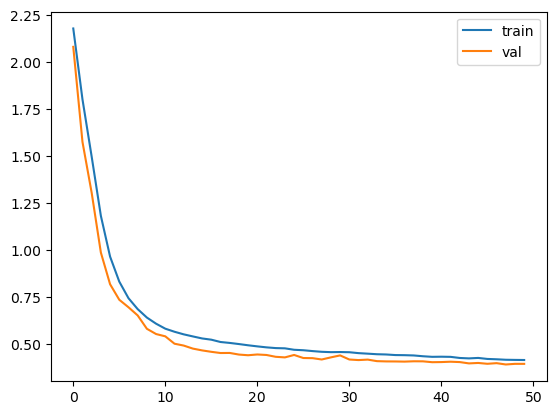

In [135]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')

plt.legend()
plt.show()

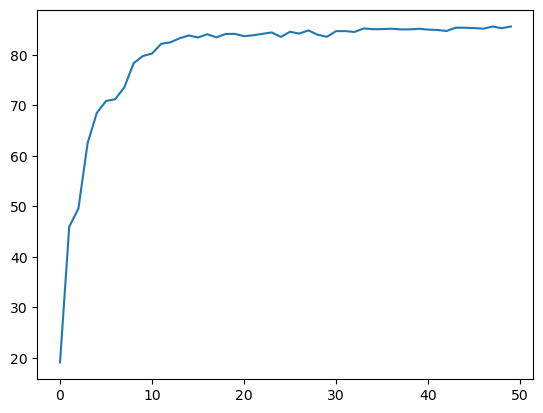

In [136]:
plt.plot(val_acc)

In [142]:
d_model = 8
max_len=50
n_classes = 9
n_epochs = 50
batch_size = 128
n_heads=2

model = Transformer(d_model, n_classes, n_heads=n_heads, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model, train_loss, val_loss, val_acc = train_model(model, train1_set, val1_set, criterion, optimizer, n_epochs, batch_size)

Epoch [1/50], Validation Accuracy: 16.75%
Epoch [2/50], Validation Accuracy: 44.87%
Epoch [3/50], Validation Accuracy: 57.12%
Epoch [4/50], Validation Accuracy: 63.57%
Epoch [5/50], Validation Accuracy: 67.43%
Epoch [6/50], Validation Accuracy: 72.87%
Epoch [7/50], Validation Accuracy: 75.45%
Epoch [8/50], Validation Accuracy: 77.13%
Epoch [9/50], Validation Accuracy: 77.69%
Epoch [10/50], Validation Accuracy: 79.32%
Epoch [11/50], Validation Accuracy: 79.49%
Epoch [12/50], Validation Accuracy: 80.85%
Epoch [13/50], Validation Accuracy: 79.01%
Epoch [14/50], Validation Accuracy: 80.78%
Epoch [15/50], Validation Accuracy: 80.39%
Epoch [16/50], Validation Accuracy: 80.59%
Epoch [17/50], Validation Accuracy: 80.18%
Epoch [18/50], Validation Accuracy: 80.57%
Epoch [19/50], Validation Accuracy: 81.16%
Epoch [20/50], Validation Accuracy: 83.12%
Epoch [21/50], Validation Accuracy: 82.17%
Epoch [22/50], Validation Accuracy: 83.21%
Epoch [23/50], Validation Accuracy: 82.64%
Epoch [24/50], Valid

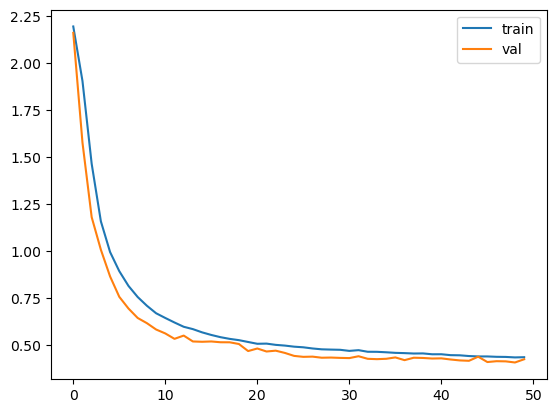

In [143]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')

plt.legend()
plt.show()

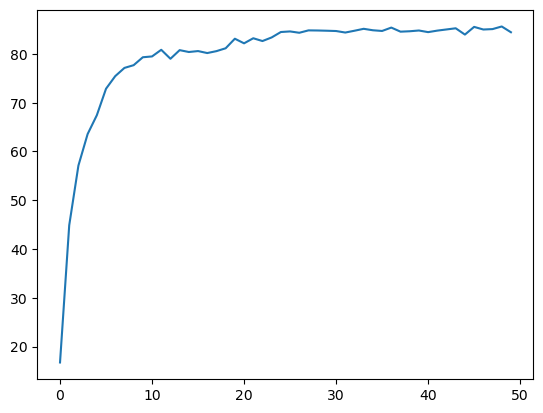

In [144]:
plt.plot(val_acc)

In [145]:
d_model = 8
max_len=50
n_classes = 9
n_epochs = 50
batch_size = 128
n_layers = 2

model = Transformer(d_model, n_classes, n_layers=n_layers, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model, train_loss, val_loss, val_acc = train_model(model, train1_set, val1_set, criterion, optimizer, n_epochs, batch_size)

Epoch [1/50], Validation Accuracy: 32.26%
Epoch [2/50], Validation Accuracy: 25.53%
Epoch [3/50], Validation Accuracy: 47.96%
Epoch [4/50], Validation Accuracy: 38.35%
Epoch [5/50], Validation Accuracy: 57.30%
Epoch [6/50], Validation Accuracy: 39.02%
Epoch [7/50], Validation Accuracy: 79.55%
Epoch [8/50], Validation Accuracy: 53.97%
Epoch [9/50], Validation Accuracy: 81.35%
Epoch [10/50], Validation Accuracy: 80.60%
Epoch [11/50], Validation Accuracy: 70.11%
Epoch [12/50], Validation Accuracy: 83.63%
Epoch [13/50], Validation Accuracy: 72.26%
Epoch [14/50], Validation Accuracy: 73.64%
Epoch [15/50], Validation Accuracy: 67.90%
Epoch [16/50], Validation Accuracy: 85.39%
Epoch [17/50], Validation Accuracy: 82.72%
Epoch [18/50], Validation Accuracy: 86.16%
Epoch [19/50], Validation Accuracy: 83.37%
Epoch [20/50], Validation Accuracy: 68.10%
Epoch [21/50], Validation Accuracy: 68.41%
Epoch [22/50], Validation Accuracy: 81.49%
Epoch [23/50], Validation Accuracy: 81.48%
Epoch [24/50], Valid